In [215]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================
import plot_data
import constraints_scipy

In [216]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs = [-0.5], observables=[qml.PauliZ(0)])

In [217]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(2)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [218]:
@qml.qnode(dev)
def circuit(phi):
    """ 
    Construct a quantum circuit with specified gates and operations.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Density matrix of the quantum system after applying gates.
    """
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    
    gamma_dephase = Dephase_factor(Tau_global)  

    qml.RX(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(H, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0) 

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

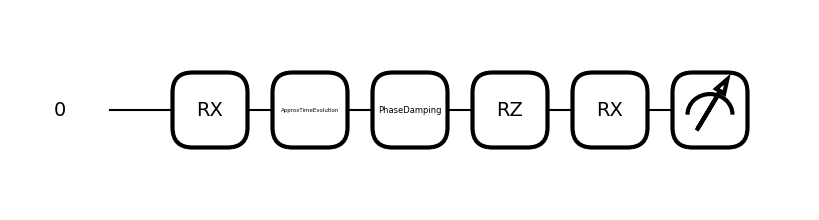

In [219]:
fig, ax = qml.draw_mpl(circuit)(1)

In [220]:
@qml.qnode(dev)
def Post_selection(phi):
    """ 
    Perform post-selection on the output of the `circuit` function.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Post-selected density matrix after applying a Kraus operator.
    """
    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.array([
        [pnp.sqrt(1 - Gamma_ps_global), 0],
        [0, 1]
    ])

    Numerator = K @ get_density_matrix @ K.conj().T
    Denominator = pnp.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

In [221]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [222]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [223]:
def lbfgsb(paras_in, constraints_in, gradient_in):
    opt_result = sp.optimize.minimize(
        fun = cost_function, 
        x0 = paras_in, 
        method = 'L-BFGS-B', 
        bounds = constraints_in,
        jac = gradient_in,
        tol = 1e-12,
        options={
            'ftol': 1e-12, 
            'gtol': 1e-12
        }
    )
    return opt_result

In [224]:
def scipy_optimization(sweep_range, initial_parameters, method, gamma_ps_idx, tau_idx):
    Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
    Data = np.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    gradient = grad(cost_function)
    hessian = jacobian(gradient)
    
    global Phi_global
    paras_temporary = 0

    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)
        
        N = int(phi_current / np.pi) * np.pi
        if gamma_ps_idx == 8e-1:
            if tau_idx == 0:
                paras_temporary = pnp.array([np.pi/2, np.pi/2])

            elif (np.pi/2 + N <= phi_current <= 2.1 + N):
                paras_temporary = pnp.array([np.pi/2, 1])
        
        constraints = constraints_scipy.get_constraints(phi_current, gamma_ps_idx, tau_idx)
        
        if method == 'LBFGSB':
            opt_result = lbfgsb(paras_temporary, constraints, gradient)
        
        print("CFI =", -opt_result.fun, "Paras =", opt_result.x)
        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x
        
    return Data

In [225]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
  
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = scipy_optimization(sweep_range, init_par, method, gamma_post_selection, tau_current)
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [226]:
sweep_range = np.array([0.0, 3*np.pi, 1e-2])
init_par = pnp.array([np.pi/2, np.pi/2])
tau_dephase = 0,
gamma_ps = 0.8

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGSB')

CFI = 4.99999861341226 Paras = [1.57079633 3.1413193 ]
CFI = 4.999998630241996 Paras = [1.57079633 3.1513255 ]
CFI = 4.999998592448064 Paras = [1.57079633 3.16133945]
CFI = 4.9999986087949875 Paras = [1.57079633 3.17131112]
CFI = 4.999998626138756 Paras = [1.57079633 3.18132696]
CFI = 4.99999862838912 Paras = [1.57079633 3.19133041]
CFI = 4.999998620452715 Paras = [1.57079633 3.201326  ]
CFI = 4.999998625525178 Paras = [1.57079633 3.21185712]
CFI = 4.9999986119762285 Paras = [1.57079633 3.22187414]


KeyboardInterrupt: 

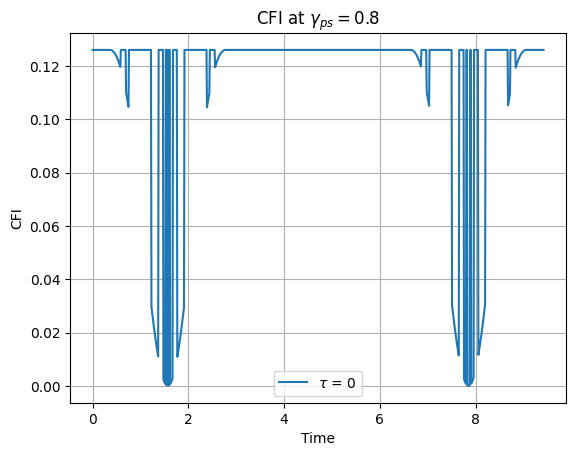

In [ ]:
plot_data.plot_result(res, tau_dephase, gamma_ps, 'CFI')

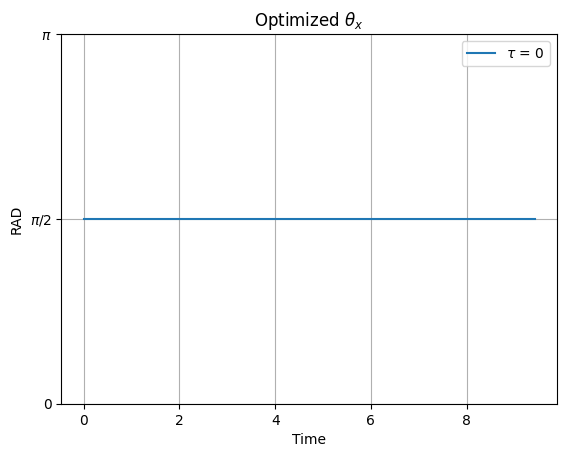

In [ ]:
plot_data.plot_result(res, tau_dephase, gamma_ps, 'theta_x')

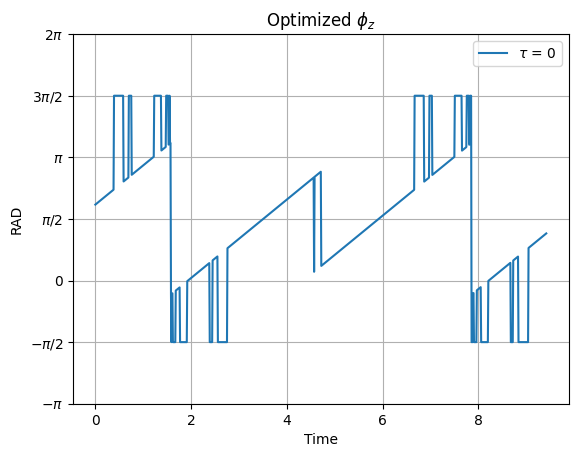

In [ ]:
plot_data.plot_result(res, tau_dephase, gamma_ps, 'phi_z')